# Loteca

In [1]:
import keras
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Ler arquivo

In [2]:
df = np.load('arquivo.npy')

In [3]:
# Define o ganhador H = casa, A = Vizitante, D = empate
for i in range(len(df)):
    df[i,8] = 'H' if (int(df[i,2]) - int(df[i,6])) > 0 else 'A' if (int(df[i,2]) - int(df[i,6])) < 0 else 'D'

In [4]:
# Cria um data frame para receber os valores
df_ = pd.DataFrame(df,columns=['Concurso','Jogo','HG','Home','S','Away','AG','Dia','Res'])

In [5]:
# Transforma as colunas de gols em inteiros
df_ = df_.astype({"HG": int, "AG": int})

In [6]:
df_.head()

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res
0,Concurso 1 (18/02/2002),1,2,FLAMENGO/RJ,,S. PAULO/SP,4,Domingo,A
1,Concurso 1 (18/02/2002),2,3,VASCO/RJ,,AMERICANO/RJ,0,Domingo,H
2,Concurso 1 (18/02/2002),3,2,SANTOS/SP,,SÃO CAETANO/SP,1,Domingo,H
3,Concurso 1 (18/02/2002),4,1,P. DESPORTOS/SP,,CORINTHIANS/SP,4,Domingo,A
4,Concurso 1 (18/02/2002),5,7,CRUZEIRO/MG,,AMÉRICA/MG,0,Sábado,H


### Frequencia de vitórias em casa (H), empates (D) e visitantes (A)

<BarContainer object of 3 artists>

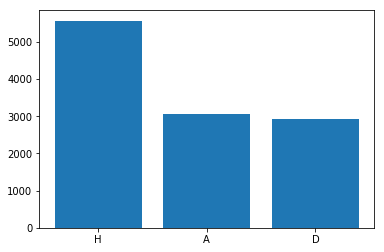

In [7]:
plt.bar(df_['Res'].value_counts().keys(),df_['Res'].value_counts())

### Média de gols dos últimos jogos

In [8]:
# Calcula a soma de gols feitos das ultimas n (window) partidas
def get_rolling_mean(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG].mean()
    return s if not(np.isnan(s)) else 0

# Calcula a soma de gols recebidos das ultimas n (window) partidas
def get_rolling_received(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    HG_AG_ = 'HG' if HG_AG == 'AG' else 'AG' if HG_AG == 'HG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG_].mean()
    return s if not(np.isnan(s)) else 0

    

### Nomes dos times

In [9]:
# Cria uma lista de nomes dos times
vocab = np.unique(np.concatenate((np.array(df_['Home'].unique()), np.array(df_['Away'].unique()))))

In [10]:
# Cria o indice de times
word2idx = {word: i for i, word in enumerate(vocab)}

In [11]:
# Retorna o indice de um time:
def word2vector(word):
    m = np.zeros(len(word2idx))
    idx = word2idx.get(word)
    if idx == '':
        raise ValueError('Time não encontrado no indice: ' + word)

    m[word2idx.get(word)] = 1
    return m.tolist()

In [12]:
# Transforma os dois times em um vetor com o flag do time correspondente e a média de gols
def prepare(H,A,pos):
    
    vector = []
    
    for x in word2vector(H):
        if math.isnan(x):
            raise ValueError('Time não encontrado no indice: ' + H)

        vector.append(x)
        
    for x in word2vector(A):
        if math.isnan(x):
            raise ValueError('Time não encontrado no indice: ' + A)
            
        vector.append(x)
        

#     Cálculo das médias de gols
#     vector.append(get_rolling_mean(df_, H, pos, 10, 'HG'))
#     vector.append(get_rolling_mean(df_, A, pos, 10, 'AG'))
    
#     vector.append(get_rolling_received(df_, H, pos, 10, 'HG'))
#     vector.append(get_rolling_received(df_, A, pos, 10, 'AG'))

    

    return vector

### Indexar os resultados

In [13]:
X = []
y = []

for ind_, row in df_.iterrows():
    X.append(prepare(row['Home'], row['Away'], ind_))        
    
    ry = [1,0,0] if int(row['HG']) > int(row['AG']) else \
    [0,1,0] if int(row['HG']) == int(row['AG']) else \
    [0,0,1] if int(row['HG']) < int(row['AG']) else [0,0,0]

    y.append(ry)

y = np.array(y).reshape(np.array(y).shape[0],3)

X = np.array(X)

# Normalizar gols
# X[:,-4:-3] = X[:,-4:-3]/X[:,-4:-3].max()
# X[:,-3:-2] = X[:,-3:-2]/X[:,-3:-2].max()
# X[:,-2:-1] = X[:,-2:-1]/X[:,-2:-1].max()
# X[:,-1:] = X[:,-1:]/X[:,-1:].max()



In [16]:
weights.min()

0.0

### Modelo

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

model = Sequential()
model.add(Dense(124, input_shape=(np.array(X).shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
model.add(Dense(3))
model.add(Activation('sigmoid'))

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Separar os datasets de treinamento e teste

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [21]:
split = 40

In [22]:
X_train, y_train, X_test, y_test = X[:-int(X.shape[0]/split)], y[:-int(y.shape[0]/split)], X[-int(X.shape[0]/split):], y[-int(y.shape[0]/split):],

In [25]:
# Cria uma matriz de pesos da massa de treino
weights = []
weights = np.zeros(y_train.shape[0])

In [26]:
for weight in range(weights.shape[0]):
    if weight > 500:
        weights[weight] = (weight**(weight/weights.shape[0]))/weight

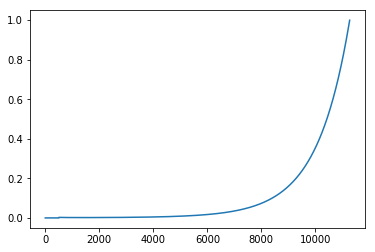

In [27]:
plt.plot(weights)

### Treinar o modelo

In [28]:
model.fit(X_train, y_train, epochs=500, batch_size=500, shuffle=True, sample_weight=weights)

Epoch 1/500
11271/11271 [==============================] - 1s 128us/step - loss: 0.0789 - acc: 0.6339
Epoch 2/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0743 - acc: 0.6546
Epoch 3/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0716 - acc: 0.6549
Epoch 4/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0703 - acc: 0.6646
Epoch 5/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0692 - acc: 0.6723
Epoch 6/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0677 - acc: 0.6713
Epoch 7/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0656 - acc: 0.6901
Epoch 8/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0630 - acc: 0.6971
Epoch 9/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0602 - acc: 0.6984
Epoch 10/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0565 - 

11271/11271 [==============================] - 0s 25us/step - loss: 0.0311 - acc: 0.7487
Epoch 82/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0309 - acc: 0.7491
Epoch 83/500
11271/11271 [==============================] - 0s 26us/step - loss: 0.0310 - acc: 0.7498
Epoch 84/500
11271/11271 [==============================] - 0s 23us/step - loss: 0.0312 - acc: 0.7488
Epoch 85/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0311 - acc: 0.7489
Epoch 86/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0309 - acc: 0.7468
Epoch 87/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0308 - acc: 0.7525
Epoch 88/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0309 - acc: 0.7515
Epoch 89/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0311 - acc: 0.7473
Epoch 90/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0307 - acc: 

11271/11271 [==============================] - 0s 23us/step - loss: 0.0298 - acc: 0.7557
Epoch 161/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0300 - acc: 0.7524
Epoch 162/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0295 - acc: 0.7527
Epoch 163/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0297 - acc: 0.7547
Epoch 164/500
11271/11271 [==============================] - 0s 26us/step - loss: 0.0297 - acc: 0.7545
Epoch 165/500
11271/11271 [==============================] - 0s 26us/step - loss: 0.0296 - acc: 0.7549
Epoch 166/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0295 - acc: 0.7541
Epoch 167/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0296 - acc: 0.7556
Epoch 168/500
11271/11271 [==============================] - 0s 23us/step - loss: 0.0295 - acc: 0.7543
Epoch 169/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.029

11271/11271 [==============================] - 0s 23us/step - loss: 0.0288 - acc: 0.7589
Epoch 240/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0288 - acc: 0.7575
Epoch 241/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0289 - acc: 0.7573
Epoch 242/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0289 - acc: 0.7572
Epoch 243/500
11271/11271 [==============================] - 0s 23us/step - loss: 0.0289 - acc: 0.7612
Epoch 244/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0288 - acc: 0.7594
Epoch 245/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0291 - acc: 0.7579
Epoch 246/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0287 - acc: 0.7568
Epoch 247/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0286 - acc: 0.7603
Epoch 248/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.028

11271/11271 [==============================] - 0s 24us/step - loss: 0.0287 - acc: 0.7566
Epoch 319/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0285 - acc: 0.7599
Epoch 320/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0285 - acc: 0.7572
Epoch 321/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0287 - acc: 0.7580
Epoch 322/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0281 - acc: 0.7598
Epoch 323/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0285 - acc: 0.7578
Epoch 324/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0281 - acc: 0.7596
Epoch 325/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0287 - acc: 0.7587
Epoch 326/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0281 - acc: 0.7598
Epoch 327/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.028

11271/11271 [==============================] - 0s 25us/step - loss: 0.0281 - acc: 0.7604
Epoch 398/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0284 - acc: 0.7598
Epoch 399/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0283 - acc: 0.7608
Epoch 400/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0283 - acc: 0.7615
Epoch 401/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0282 - acc: 0.7581
Epoch 402/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0282 - acc: 0.7599
Epoch 403/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0282 - acc: 0.7598
Epoch 404/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0282 - acc: 0.7607
Epoch 405/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0277 - acc: 0.7599
Epoch 406/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.028

11271/11271 [==============================] - 0s 23us/step - loss: 0.0279 - acc: 0.7602
Epoch 477/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0284 - acc: 0.7605
Epoch 478/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0278 - acc: 0.7607
Epoch 479/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0282 - acc: 0.7596
Epoch 480/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0279 - acc: 0.7608
Epoch 481/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.0277 - acc: 0.7602
Epoch 482/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0278 - acc: 0.7597
Epoch 483/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0280 - acc: 0.7631
Epoch 484/500
11271/11271 [==============================] - 0s 25us/step - loss: 0.0281 - acc: 0.7617
Epoch 485/500
11271/11271 [==============================] - 0s 24us/step - loss: 0.028

In [29]:
model.evaluate(X_test, y_test, verbose=1)

289/289 [==============================] - 0s 266us/step


[1.6224988888704241, 0.6459054408601411]

### Avaliar precisão

In [30]:
# Cria as colunas com os resultados reais e as apostas
def aposta(dr,p):
    dr['RC1'] = 'X' if dr['HG'] > dr['AG'] else ''
    dr['RCM'] = 'X' if dr['HG'] == dr['AG'] else ''
    dr['RC2'] = 'X' if dr['HG'] < dr['AG'] else ''
    
    
#     Criar apostas com jogos simples, duplos e triplos:
    c=0
    if p[0,0] > p.mean():
        dr['AC1'] = 'X' 
        c += 1
    else:
        dr['AC1'] = ''
    

    if p[0,1] > p.mean():
        dr['ACM'] = 'X' 
        c += 1
    else:
        dr['ACM'] = ''

    if p[0,2] > p.mean():
        dr['AC2'] = 'X' 
        c += 1
    else:
        dr['AC2'] = ''
        
#         Criar marcador de jogos duplos e triplos
    if c==2:
        dr['D']='D'
    else:
        dr['D']=''
    if c==3:
        dr['T']='T'
    else:
        dr['T']=''
        

    return dr
    
    
    

In [31]:
dfx = df_[int(-df_.shape[0]/split):]

ds = []

X_ = X[-int(X.shape[0]/split):]

prec = []

i=0
for idx, dfr in dfx.iterrows():
    
    pa = prepare(dfr['Home'], dfr['Away'],idx)

    p = model.predict(np.array(pa).reshape(1,len(pa)))
    
    i += 1
    
#     Quantificar a previsão e comparar com o real
    px = 'H' if p[0,0] > p.mean() else 'A' if p[0,2] > p.mean() else 'D' if p[0,1] > p.mean() else ''
    
    prec.append(1 if px == dfr['Res'] else 0)
    
    dfr['S'] = px
    
#     Cria um dataframe com os resultados para report
    ds.append(aposta(dfr,p))
    
dfs = pd.DataFrame(ds)

print(round((abs(np.mean(prec))) * 100,0), '%')
    

43.0 %


In [35]:
dfs[dfs['Concurso']=='Concurso 825 (05/11/2018)']

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res,RC1,RCM,RC2,AC1,ACM,AC2,D,T
11532,Concurso 825 (05/11/2018),1,0,FLUMINENSE/RJ,A,VASCO DA GAMA/RJ,1,Sábado,A,,,X,,,X,,
11533,Concurso 825 (05/11/2018),2,3,PALMEIRAS/SP,H,SANTOS/SP,2,Sábado,H,X,,,X,,X,D,
11534,Concurso 825 (05/11/2018),3,2,SÃO PAULO/SP,H,FLAMENGO/RJ,2,Domingo,D,,X,,X,,,,
11535,Concurso 825 (05/11/2018),4,1,AVAÍ/SC,H,LONDRINA/PR,1,Sábado,D,,X,,X,,,,
11536,Concurso 825 (05/11/2018),5,1,ATLÉTICO/GO,H,FORTALEZA/CE,2,Sábado,A,,,X,X,,,,
11537,Concurso 825 (05/11/2018),6,2,CRB/AL,H,BOA ESPORTE/MG,1,Sábado,H,X,,,X,X,,D,
11538,Concurso 825 (05/11/2018),7,0,CORITIBA/PR,H,GUARANI/SP,2,Sábado,A,,,X,X,X,,D,
11539,Concurso 825 (05/11/2018),8,0,ATLÉTICO/MG,D,GRÊMIO/RS,1,Sábado,A,,,X,,X,,,
11540,Concurso 825 (05/11/2018),9,1,AMÉRICA/MG,A,CRUZEIRO/MG,2,Domingo,A,,,X,,,X,,
11541,Concurso 825 (05/11/2018),10,1,BOTAFOGO/RJ,H,CORINTHIANS/SP,0,Domingo,H,X,,,X,,,,


In [34]:
dfs[dfs['S']==dfs['Res']].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 806 (28/06/2018)  Concurso 806 (28/06/2018)     4
Concurso 807 (02/07/2018)  Concurso 807 (02/07/2018)     3
Concurso 808 (09/07/2018)  Concurso 808 (09/07/2018)     8
Concurso 809 (16/07/2018)  Concurso 809 (16/07/2018)     4
Concurso 810 (23/07/2018)  Concurso 810 (23/07/2018)     8
Concurso 811 (30/07/2018)  Concurso 811 (30/07/2018)     6
Concurso 812 (06/08/2018)  Concurso 812 (06/08/2018)     6
Concurso 813 (13/08/2018)  Concurso 813 (13/08/2018)     5
Concurso 814 (20/08/2018)  Concurso 814 (20/08/2018)     4
Concurso 815 (27/08/2018)  Concurso 815 (27/08/2018)     7
Concurso 816 (03/09/2018)  Concurso 816 (03/09/2018)     8
Concurso 817 (10/09/2018)  Concurso 817 (10/09/2018)    10
Concurso 818 (17/09/2018)  Concurso 818 (17/09/2018)     5
Concurso 819 (25/09/2018)  Concurso 819 (25/09/2018)     6
Concurso 820 (01/10/2018)  Concurso 820 (01/10/2018)     4
Concurso 821 (08/10/2018)  Concurso 821 (08/10/2018)     6
Con

In [32]:
# Considera os duplos e triplos
# RC1	RCM	RC2	AC1	ACM	AC2
dfs[((dfs['RC1']==dfs['AC1'])&(dfs['RC1']=='X')) | ((dfs['RC2']==dfs['AC2'])&(dfs['RC2']=='X')) | ((dfs['RCM']==dfs['ACM'])&(dfs['RCM']=='X'))].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 806 (28/06/2018)  Concurso 806 (28/06/2018)     5
Concurso 807 (02/07/2018)  Concurso 807 (02/07/2018)     4
Concurso 808 (09/07/2018)  Concurso 808 (09/07/2018)     8
Concurso 809 (16/07/2018)  Concurso 809 (16/07/2018)     5
Concurso 810 (23/07/2018)  Concurso 810 (23/07/2018)     8
Concurso 811 (30/07/2018)  Concurso 811 (30/07/2018)     7
Concurso 812 (06/08/2018)  Concurso 812 (06/08/2018)     7
Concurso 813 (13/08/2018)  Concurso 813 (13/08/2018)     6
Concurso 814 (20/08/2018)  Concurso 814 (20/08/2018)     4
Concurso 815 (27/08/2018)  Concurso 815 (27/08/2018)     9
Concurso 816 (03/09/2018)  Concurso 816 (03/09/2018)     9
Concurso 817 (10/09/2018)  Concurso 817 (10/09/2018)    11
Concurso 818 (17/09/2018)  Concurso 818 (17/09/2018)     6
Concurso 819 (25/09/2018)  Concurso 819 (25/09/2018)     6
Concurso 820 (01/10/2018)  Concurso 820 (01/10/2018)     5
Concurso 821 (08/10/2018)  Concurso 821 (08/10/2018)     7
Con

In [33]:
# Preço das apostas
2**dfs[dfs['D']=='D'].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 806 (28/06/2018)  Concurso 806 (28/06/2018)     2
Concurso 807 (02/07/2018)  Concurso 807 (02/07/2018)     4
Concurso 809 (16/07/2018)  Concurso 809 (16/07/2018)     4
Concurso 810 (23/07/2018)  Concurso 810 (23/07/2018)     4
Concurso 811 (30/07/2018)  Concurso 811 (30/07/2018)    16
Concurso 812 (06/08/2018)  Concurso 812 (06/08/2018)     4
Concurso 813 (13/08/2018)  Concurso 813 (13/08/2018)     4
Concurso 814 (20/08/2018)  Concurso 814 (20/08/2018)    16
Concurso 815 (27/08/2018)  Concurso 815 (27/08/2018)    16
Concurso 816 (03/09/2018)  Concurso 816 (03/09/2018)    32
Concurso 817 (10/09/2018)  Concurso 817 (10/09/2018)    16
Concurso 818 (17/09/2018)  Concurso 818 (17/09/2018)     4
Concurso 819 (25/09/2018)  Concurso 819 (25/09/2018)     4
Concurso 820 (01/10/2018)  Concurso 820 (01/10/2018)     4
Concurso 821 (08/10/2018)  Concurso 821 (08/10/2018)     8
Concurso 822 (15/10/2018)  Concurso 822 (15/10/2018)     8
Con

### Lista de times

In [ ]:
vocab

### Realizar previsão

In [ ]:
H = 'LIVERPOOL/ING'
A = 'TOTTENHAM/ING'

prep = [prepare(H,A,1)]
    
prepx = np.array(prep).reshape(np.array(prep).shape[0],np.array(prep).shape[1])
    
p = model.predict(prepx)


print(p)


In [ ]:
p[0,2]

In [ ]:
p.mean()